# A General Theory for Stock Dynamics of Populations and Built and Natural Environments
by Dirk Lauinger, Romain G. Billy, Daniel B. Müller, Felipe Vásquez

01 February 2021

Data analysis for Figures 4 and 5

## Lifetime vs. death rate

Figure 4 compares the evolution of in- and outflows under a constant lifetime and a constant death rate, equal to the inverse of the lifetime, for a model with logistic stock growth. 

In [1]:
# -- import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
# -- define the in- and outflows as a function of the stock and the death rate or the lifetime

# death rate approach
def Od(S, d):
    return d*S[1:]
def Id(S, d):
    dS = np.diff(S)   # calculate stock change
    return dS + Od(S, d)

# lifetime approach
def IL(S, L):
    dS = np.diff(S)   # calculate stock change
    # apply Equation (8)
    return np.linalg.solve(np.identity(len(L)) - L, dS)
def OL(S, L):
    dS = np.diff(S)   # calculate stock change
    return IL(S, L) - dS

In [3]:
# -- define problem parameters
N = 100               # length of planning horizon (periods)
k = 15                # shape factor for the logistic stock growth (1/time)
m = 0.5               # mean value of the logistic function (time)
dt = 1/N              # duration of each period (time)
d = 0.1               # death rate per period (1/time)
L_exp = 10*dt         # mean lifetime (time)
L_std = 3*dt          # standard deviation (time)
# define lifetime function: truncated normal distribution in this case (needs normalization)
def normal(x, mu, std):
    return np.exp( -((x - mu)/std)**2/2 )/(std*np.sqrt(2*np.pi))
# build lifetime matrix
L = np.zeros((N,N))
for n in range(N):
    L = L + np.diag(np.ones(N - n)*normal(n*dt, L_exp, L_std), k = -n)
# normalize
L = L/L[:,0].sum()
# time-steps
t = np.arange(0,1.01,dt)
# stock evolution
S = 1/(1 + np.exp(-k*(t-m)))

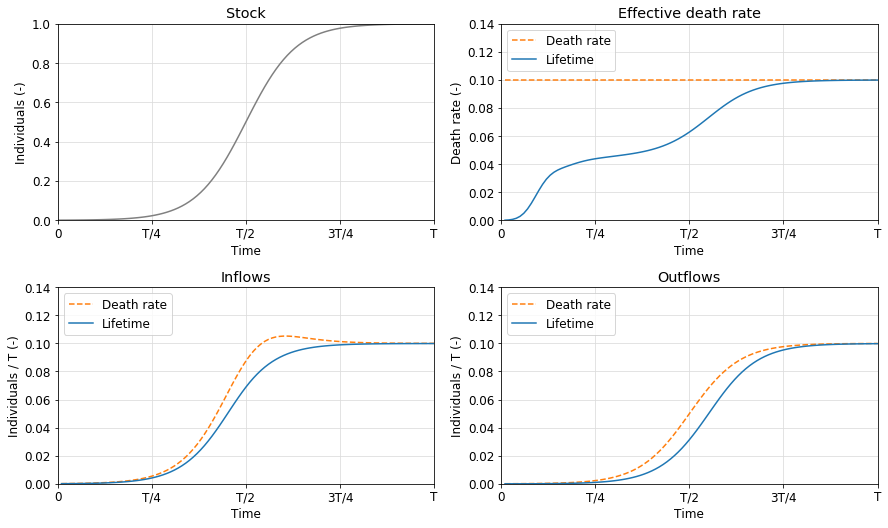

In [4]:
# -- plot the figure
fig = plt.figure(figsize = (12.5, 7.5))
plt.rcParams.update({'font.size': 12})
# Stock
ax1 = plt.subplot(221, fc = 'w')
plt.plot(t, S, color='grey')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks([0, 0.25, 0.5, 0.75, 1], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xlabel('Time')
plt.ylabel('Individuals (-)')
plt.title('Stock')
plt.grid(color='gainsboro')
# Effective Death Rate
ax2 = plt.subplot(222, facecolor = 'w')
plt.plot(t[1:], Od(S, d)/S[1:], linestyle = '--', color = 'tab:orange', label = 'Death rate')
plt.plot(t[1:], OL(S, L)/S[1:], linestyle = '-',  color = 'tab:blue', label = 'Lifetime')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'upper left')
plt.xlim([0, 1])
plt.ylim([0, 0.14])
plt.xticks([0, 0.25, 0.5, 0.75, 1], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xlabel('Time')
plt.ylabel('Death rate (-)')
plt.title('Effective death rate')
plt.grid(color='gainsboro')
# Inflows
ax3 = plt.subplot(223, facecolor = 'w')
plt.plot(t[1:], Id(S, d), '--', label = 'Death rate', color = 'tab:orange')
plt.plot(t[1:], IL(S, L), label='Lifetime', color = 'tab:blue')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'upper left')
plt.xlim([0, 1])
plt.ylim([0, 0.14])
plt.xticks([0, 0.25, 0.5, 0.75, 1], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xlabel('Time')
plt.ylabel('Individuals / T (-)')
plt.title('Inflows')
plt.grid(color='gainsboro')
# Outflows
ax4 = plt.subplot(224, facecolor = 'w')
plt.plot(t[1:], Od(S, d), '--', color = 'tab:orange', label = 'Death rate')
plt.plot(t[1:], OL(S, L), label='Lifetime', color = 'tab:blue')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'upper left')
plt.xlim([0, 1])
plt.ylim([0, 0.14])
plt.xticks([0, 0.25, 0.5, 0.75, 1], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xlabel('Time')
plt.ylabel('Individuals / T (-)')
plt.title('Outflows')
plt.grid(color='gainsboro')
# optimize layout
fig.tight_layout()
fig.savefig('Death_Rate_vs_Lifetime.pdf',bbox_inches='tight')
fig.savefig('Death_Rate_vs_Lifetime.png',bbox_inches='tight', dpi=600)

## Time-varying vs constant lifetime
Figure 5 computes the native female population born after 1850 and its deaths based on live births and average and cohort-explicit survival curves from 1850 to 2000 for England and Wales.

Data            | Source
:---            | :---
Births          | UK Office for National Statistics - [*Births in England and Wales: summary tables*](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/livebirths/datasets/birthsummarytables)
Survival Curves | UK Office for National Statistics - [*Past and projected data from the period and cohort life tables, 2016-based: England and Wales, 1841 to 2066*](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/lifeexpectancies/adhocs/008693pastandprojecteddatafromtheperiodandcohortlifetables2016basedenglandandwales1841to2066)

In [5]:
# -- import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

In [6]:
# -- define functions

def O(I, L):
    return L.dot(I)
def S(I, L, S0):
    dS = (I - O(I, L)).cumsum()     # calculate stock change
    dS.index = dS.index + 1         # increment index
    dS[1850] = S0                   # account for initial condition
    return dS.sort_index()          # return sorted index

# transform cohort-explicit into average lifetime matrix
def L_avg(L, I):
    N = len(L)
    df = np.zeros((N, N)) 
    for k in range(N):
        # live-birth weighted-average for mortality in each age class
        df = df + np.diag(sum(np.diag(L, -k)*I.iloc[:N-k])/sum(I.iloc[:N-k])*np.ones(N-k), -k)
        # normalize
        df = df * 1/sum(df[:,0])
    return pd.DataFrame(df, columns = np.arange(1850, 2000), index = np.arange(1850, 2000))

In [7]:
# -- define problem parameters
N = 2000 - 1850                                                                                                   # length of planning horizon (years)
S0 = 0                                                                                                            # initial state-of-charge
I = pd.read_excel('Data.xlsx', sheet_name = 'Births', index_col = 'Year', nrows = 151, skiprows = 2)\
                 ['Live Births'].iloc[::-1]                                                                       # live births
# exclude the year 2000 from live births
I = I[:-1]
survival_cohorts = pd.read_excel('Data.xlsx', sheet_name = 'Survival_Matrix', index_col = 'Year', skiprows = 2)   # cohort-explicit survival curves
# preprocess survival curves
survival_cohorts.fillna(0, inplace = True)
# calculate cohort-explicit lifetime matrix based on survival curves: lower-triangular because we work with column- rather than row-vectors
L_cohorts = -survival_cohorts.diff().iloc[1:1+N,:N] + np.diag(np.ones(N-1), k=1)
# adjust index
L_cohorts.index = L_cohorts.index - 1
# compute average survival curves from 1850 to 2000
survival_average = np.diag(np.diag(survival_cohorts.loc[:2000]))
# live-birth weighted average survival rate for each age class
for k in np.arange(1, N+1):
    survival_average = survival_average + np.diag(sum(np.diag(survival_cohorts.loc[:2000], -k)*I.iloc[:N+1-k])/sum(I.iloc[:N+1-k])*np.ones(N+1-k), -k)
survival_average = pd.DataFrame(survival_average, columns = np.arange(1850, 2001), index = np.arange(1850, 2001))
# compute corresponding lifetime matrix: lower-triangular because we work with column- rather than row-vectors
L_average = -survival_average.diff().iloc[1:1+N,:N] + np.diag(np.ones(N-1), k=1)
# adjust index
L_average.index = L_average.index - 1

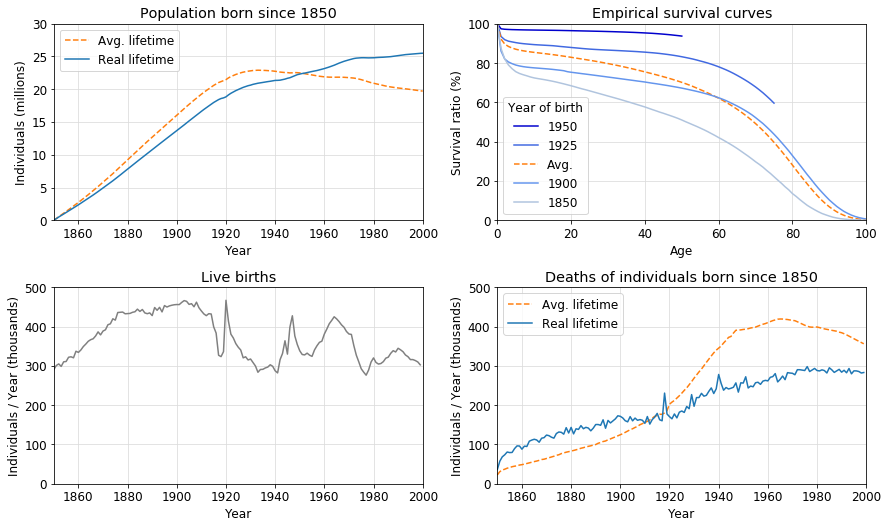

In [8]:
# -- plot the figure
fig = plt.figure(figsize = (12.5, 7.5))
plt.rcParams.update({'font.size': 12})
# Stock
ax3 = plt.subplot(221, facecolor = 'w')
plt.plot(S(I, L_average, S0)/1e6, '--', label = 'Avg. lifetime', color = 'tab:orange')
plt.plot(S(I, L_cohorts, S0)/1e6, label='Real lifetime', color = 'tab:blue')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'upper left')
plt.xlim([1850, 2000])
plt.ylim(0, 30)
plt.xlabel('Year')
plt.ylabel('Individuals (millions)')
plt.title('Population born since 1850')
plt.grid(color='gainsboro')
# Empirical Survival Curves
ax2 = plt.subplot(222, facecolor = 'w')
plt.plot(np.arange(51), 100*survival_cohorts[1950].loc[1950:2000], label = '1950', color = 'mediumblue')
plt.plot(np.arange(76), 100*survival_cohorts[1925].loc[1925:2000], label = '1925', color = 'royalblue')
plt.plot(np.arange(121), 100*survival_average[1850].loc[1850:1970], '--', color = 'tab:orange', label = 'Avg.')
plt.plot(np.arange(101), 100*survival_cohorts[1900].loc[1900:2000], label = '1900', color = 'cornflowerblue')
plt.plot(np.arange(121), 100*survival_cohorts[1850].loc[1850:1970], label = '1850', color = 'lightsteelblue')
lg = plt.legend(title = 'Year of birth', facecolor = 'w', fontsize = '12', loc = 'lower left')
lg.get_title().set_fontsize(12)
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.xlabel('Age')
plt.ylabel('Survival ratio (%)')
plt.title('Empirical survival curves')
plt.grid(color='gainsboro')
# Live births
ax1 = plt.subplot(223, fc = 'w')
plt.plot(I/1000, color='grey')
plt.xlim([1850, 2000])
plt.ylim(0, 500)
plt.xlabel('Year')
plt.ylabel('Individuals / Year (thousands)')
plt.title('Live births')
plt.grid(color='gainsboro')
# Deaths
ax4 = plt.subplot(224, facecolor = 'w')
plt.plot(O(I, L_average)/1e3, '--', color = 'tab:orange', label = 'Avg. lifetime')
plt.plot(O(I, L_cohorts)/1e3, label='Real lifetime', color = 'tab:blue')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'upper left')
plt.xlim([1850, 2000])
plt.ylim(0, 500)
plt.xlabel('Year')
plt.ylabel('Individuals / Year (thousands)')
plt.title('Deaths of individuals born since 1850')
plt.grid(color='gainsboro')
# optimize layout
fig.tight_layout()
fig.savefig('Varying_vs_Cst_Lifetime.pdf',bbox_inches='tight')
fig.savefig('Varying_vs_Cst_Lifetime.png',bbox_inches='tight', dpi=600)